<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#加载数据" data-toc-modified-id="加载数据-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>加载数据</a></span></li><li><span><a href="#精度-召回率-F" data-toc-modified-id="精度-召回率-F-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>精度-召回率-F</a></span></li><li><span><a href="#加载模型" data-toc-modified-id="加载模型-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>加载模型</a></span></li><li><span><a href="#示例图" data-toc-modified-id="示例图-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>示例图</a></span></li><li><span><a href="#召回率随半径变化" data-toc-modified-id="召回率随半径变化-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>召回率随半径变化</a></span><ul class="toc-item"><li><span><a href="#半长轴50以下的椭圆" data-toc-modified-id="半长轴50以下的椭圆-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>半长轴50以下的椭圆</a></span></li></ul></li></ul></div>

In [1]:
base_path = r'/home/liucc/Workspace/02_Ellipse/03_results/01_industry/05_ellipse_result/'
label_path = r'/home/liucc/Workspace/02_Ellipse/03_results/01_industry/04_ellipse_label/'
raw_path = r'/home/liucc/Workspace/02_Ellipse/03_results/01_industry/01_raw/'

In [2]:
import os 
dirs = os.listdir(base_path)
dirs = [d for d in dirs if d[0]!='.']
dirs.sort()
print(dirs)

['2012_param', '2014_fast', '2017_fast', '2018_high', 'canny', 'proposed']


In [3]:
fnames = os.listdir(label_path)
fnames = [n.split('.')[0] for n in fnames if n[-3:]=='txt']
fnames.sort()
print(fnames[:10])

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


# 加载数据

In [4]:
import sys
import imageio

gts = []
raws = []

for name in fnames:
    
    lname = label_path + name + '.txt'
    rname = raw_path + name + '.jpg'
    
    im_raw = imageio.imread(rname)
    raws.append(im_raw)
    
    with open(lname,'r') as f:
        txt = f.read()
        
        ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n')]
        
        gts.append(ells_t)

print(len(raws),len(gts))

66 66


# 精度-召回率-F

In [5]:
import re
from experiment import * 

results = dict()

for dd in dirs:
    
    prs = []
    
    if len(os.listdir(base_path + dd))<len(fnames):
        continue
    
    for name in fnames:
        lname = base_path + dd + '/' + name + '.txt'

        with open(lname,'r') as f:
            txt = f.read()
            txt = txt.strip()
            
            txt = re.sub(r'[\f\r\t\v]+',' ',txt)
            if txt!='':
                ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n') if len(l.split(' '))==5]
            
                prs.append(ells_t)
            else:
                prs.append([])
            
    results[dd] = prs
    print(f'Algorithm:{dd}')
    
    precision,recall,F1,pr_ratio,gt_ratio = cal_metrics(prs,gts)
    
    print('  Precision:%.4f' % precision)
    print('  Recall:   %.4f' % recall)
    print('  F1 Score: %.4f' % F1)
    print('')

Algorithm:2012_param
  Precision:0.6615
  Recall:   0.1819
  F1 Score: 0.2854

Algorithm:2014_fast
  Precision:0.4879
  Recall:   0.2701
  F1 Score: 0.3477

Algorithm:2017_fast
  Precision:0.4826
  Recall:   0.2341
  F1 Score: 0.3153

Algorithm:2018_high
  Precision:0.7945
  Recall:   0.3054
  F1 Score: 0.4412

Algorithm:canny
  Precision:0.8187
  Recall:   0.5127
  F1 Score: 0.6305

Algorithm:proposed
  Precision:0.8165
  Recall:   0.7123
  F1 Score: 0.7608



# 加载模型

In [6]:
sys.path.append('/home/liucc/Workspace/02_Ellipse/02_algorithm/01_cnn')
from cnn_model import *

model_path = r'/home/liucc/Workspace/02_Ellipse/06_model/'
model_name = r'ellipse-2'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = RestoreNet().to(device)

model.load_state_dict(torch.load(f'{model_path}{model_name}.mdl')['state_dict'])

# 示例图

In [ ]:
%matplotlib inline
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/01_data')
from cc_process_image import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.color import rgb2gray
from pylab import *
from skimage.morphology import thin

from matplotlib.font_manager import FontProperties
fp = FontProperties(family="DejaVu Sans",size=18)

title = {'2012_param':'ELSD',
         '2014_fast':'Fornaciari',
         '2017_fast':'Qi',
         '2018_high':'Lu',
         'canny':"Edge",
         'Raw Edge':"Edge",
         'Thin Edge':"Thin Edge",
         'proposed':'Our',
         'original':'Original',
         'GT':'GT'}

examples = list(range(10))
num = len(examples)

hs = np.array([m.shape[0]/m.shape[1] for m in raws])
hs = hs[examples]

segs = ['2012_param','2014_fast','2017_fast','2018_high','Raw Edge','proposed']
anum = len(segs)+2

fig = plt.figure(figsize=(20,sum(hs)*20/anum+0.1),dpi=300)
gs = gridspec.GridSpec(num,anum,
                       wspace=0.0,
                       hspace=0.0,
                       width_ratios=[1]*anum,
                       height_ratios=hs,
                       )

for i,alg in enumerate(segs):
    
    prs = results[alg]
                      
    for j in range(num):
        
        ax = fig.add_subplot(gs[j,i+2])
        _id = examples[j]
        raw = raws[_id]
        
        if alg=="Thin Edge":
            im = preprocess_image(rgb2gray(raw))
            edge = predict(model,im,device)
            edge = postprocess_image(edge,thr=0.5)
            edge = thin(edge)
            ax.imshow(edge,cmap='gray',interpolation="bilinear")
        elif alg=="Raw Edge":
            im = preprocess_image(rgb2gray(raw))
            edge = predict(model,im,device)
            ax.imshow(edge,cmap='gray',interpolation="bilinear")
        else:
            pr = prs[_id]
            draw_ellipse(pr,ax,'red',1,wire=True)
            gray = rgb2gray(raw)
            ax.imshow(gray,cmap='gray',alpha=0.5)
        
        if j==0:
            ax.set_title(title[alg],fontproperties=fp)
            
        ax.axis('off')
    
for j in range(num):
    ax = fig.add_subplot(gs[j,0])
    
    _id = examples[j]
    if j==0:
        ax.set_title(title['original'],fontproperties=fp)
        
    ax.imshow(raws[_id])
    ax.axis('off')
    
for j in range(num):
    ax = fig.add_subplot(gs[j,1])
    
    _id = examples[j]
    gray = rgb2gray(raws[_id])
    draw_ellipse(gts[_id],ax,'red',1,wire=True)
    if j==0:
        ax.set_title(title['GT'],fontproperties=fp)
        
    ax.imshow(gray,cmap='gray',alpha=0.5)
    ax.axis('off')
    


plt.show()

pp = PdfPages('images/comparison_industry.pdf')
pp.savefig(fig)
pp.close()

# 召回率随半径变化

In [14]:
import re
from experiment import * 

def get_recalls(prs,gts):
    recalled = []
    missed = []
    for pr,gt in zip(prs,gts):
        r1,r2 = cal_ratio_all(pr,gt)
        
        for i in r2:
            
            if r2[i]>0.7:
                recalled.append(min(gt[i][2],gt[i][3]))
            else:
                missed.append(min(gt[i][2],gt[i][3]))
    
    return recalled,missed

In [15]:
recalls = dict()
misses = dict()

for dd in dirs:
    
    prs = []
    
    if len(os.listdir(base_path + dd))<len(fnames):
        continue
    
    for name in fnames:
        lname = base_path + dd + '/' + name + '.txt'

        with open(lname,'r') as f:
            txt = f.read()
            txt = txt.strip()
            
            txt = re.sub(r'[\f\r\t\v]+',' ',txt)
            if txt!='':
                ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n') if len(l.split(' '))==5]
            
                prs.append(ells_t)
            else:
                prs.append([])
            
    recalls[dd],misses[dd] = get_recalls(prs,gts)
    
    print(f'Algorithm:{dd}')
    


Algorithm:2012_param
Algorithm:2014_fast
Algorithm:2017_fast
Algorithm:2018_high
Algorithm:canny
Algorithm:proposed


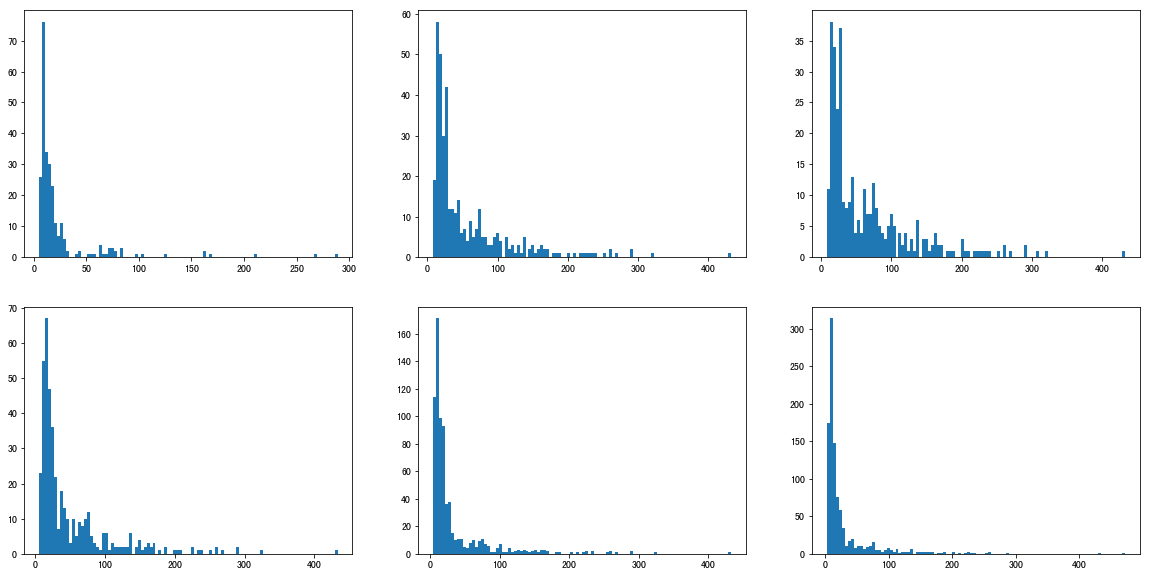

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
_,axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

axes = axes.reshape(-1)
for dd,ax in zip(recalls,axes):
    data = recalls[dd]
    data = np.round(data)
    
    ax.hist(data,bins=100)
    
plt.show()

## 半长轴50以下的椭圆

In [17]:
bars = dict()
ranges = [(0,10),(10,100),(100,Inf)]
for dd in recalls:
    bars[dd] = []
    for minor1,minor2 in ranges:
        num_recall = len([b for b in recalls[dd] if b<=minor2 and b>minor1])
        num_miss = len([b for b in misses[dd] if b<=minor2 and b>minor1])
        bars[dd].append(num_recall/(num_recall+num_miss))
    


In [18]:
num_10 = len([b for b in recalls['proposed']+misses['proposed'] if b<=10])
num_10_100 = len([b for b in recalls['proposed']+misses['proposed'] if b<=100 and b>10])
num_100_ = len([b for b in recalls['proposed']+misses['proposed'] if b>100])
num_all = len(recalls['proposed']+misses['proposed'])

ratio_10 = num_10/(num_all)
ratio_10_100 = num_10_100/(num_all)
ratio_100_ = num_100_/(num_all)

print("ratio_10:"+str(ratio_10))
print("ratio10_100:"+str(ratio_10_100))
print("ratio100+:"+str(ratio_100_))

ratio_10:0.4675599435825106
ratio10_100:0.4696755994358251
ratio100+:0.06276445698166432


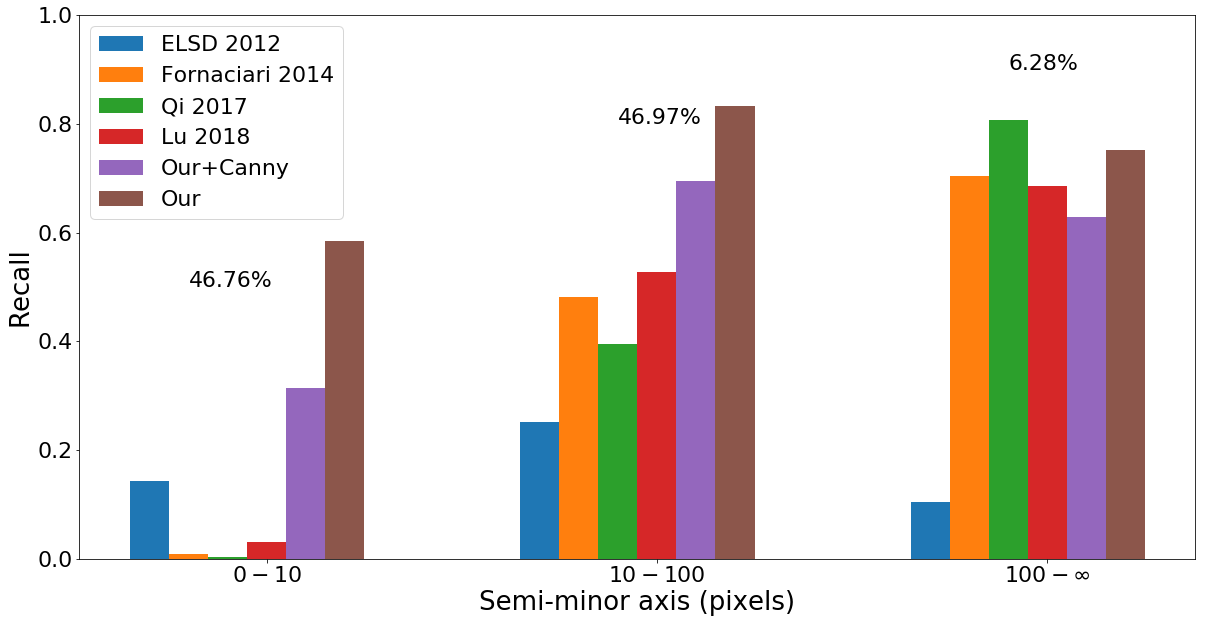

In [19]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

fp = FontProperties(family="DejaVu Sans",size=22)
fp2 = FontProperties(family="DejaVu Sans",size=26)

fig, ax = plt.subplots(figsize=(20,10))

xt = np.arange(len(ranges))
width = 0.1
for i,dd in enumerate(bars):
    ax.bar(xt+(i-3)*0.1,bars[dd],width,label=title[dd])
    
ax.set_yticks(np.arange(0,1.1,0.2))
ax.set_yticklabels(['%.1f'%v for v in np.arange(0,1.1,0.2)], fontproperties=fp)
ax.set_xticks(xt)
ax.set_xticklabels(['$0-10$','$10-100$','$100- \infty$'],fontproperties=fp)
ax.set_xlabel('Semi-minor axis (pixels)',fontproperties=fp2)
ax.set_ylabel('Recall',fontproperties=fp2)

ax.text(-0.2, 0.5, "46.76%", fontproperties=fp)
ax.text(0.9, 0.8, "46.97%", fontproperties=fp)
ax.text(1.9, 0.9, "6.28%", fontproperties=fp)
ax.legend(prop =fp)

plt.show()

pp = PdfPages('images/comparison_recall.pdf')
pp.savefig(fig)
pp.close()

